In [347]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

绘制MPAS输出降水的时间序列，和CMORPH之间的对应，以及误差；便于说明问题绘制了分位数图
因为CN05.1存在mask数据，因此需要对输出数据进行处理，用NCL+CDO来处理（在前一个文件夹，precip_preprocess中进行）

In [348]:
# 读取数据
# year = "2006"
# 注释掉的是原始数据，此后的是进行了mask之后的数据
# dir_vr = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/pre/" + "daily_pre_03-15.nc"
dir_vr = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" + "mask_vr_pre_03-15.nc"
ds_vr = xr.open_dataset(dir_vr)
# ds_vr

# dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_03-15.nc"
dir_rcm = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" + "mask_rcm_pre_03-15.nc"
ds_rcm = xr.open_dataset(dir_rcm)
# ds_rcm

# obs_cmorph = "/raid52/yycheng/MPAS/REFERENCE/CMORPH/DAILY/cdo_merge_daily/*.nc"
# ds_cmorph = xr.open_mfdataset(obs_cmorph, combine='by_coords',concat_dim='time')
obs_cmorph = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" + "mask_sel_CMORPH_03-15.nc"
ds_cmorph = xr.open_dataset(obs_cmorph)

obs_cn051  = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" +  "mask_sel_CN05.1_Pre_1961_2018_daily_025x025.nc"
ds_cn051 = xr.open_dataset(obs_cn051)

ds_cn051_time_loc_year = (ds_cn051.time.dt.year >= 2003) & (ds_cn051.time.dt.year <= 2015)
ds_cn051_time_loc_month= (ds_cn051.time.dt.month>=    4) & (ds_cn051.time.dt.month <= 8)
ds_cn051_sel = ds_cn051.isel(time = ds_cn051_time_loc & ds_cn051_time_loc_month)

# ds_cmorph
# precip_obs = ds_disk["precip_CMORPH"]
# precip_mod = ds_disk["precip_MPAS"]
vr_mean     = ds_vr['precip_MPAS'].mean(dim=["longitude","latitude"])
rcm_mean    = ds_rcm['precip_MPAS'].mean(dim=["longitude","latitude"])
cmorph_mean = ds_cmorph['cmorph'].mean(dim=["lon","lat","lev"]) # remove single dimension
cn051_mean  = ds_cn051_sel['pre'].mean(dim=['lon','lat'])


_mean 是不同数据的时间序列，下面将进行不同的groupby，绘制具体的序列

In [349]:
# 针对 day 的groupby + mean (dayofyear)

cn051_dayofyear = cn051_mean.groupby('time.dayofyear').mean('time')
cmorph_dayofyear = cmorph_mean.groupby('time.dayofyear').mean('time')
vr_dayofyear = vr_mean.groupby('Time.dayofyear').mean('Time')
rcm_dayofyear = rcm_mean.groupby('Time.dayofyear').mean('Time')

# 选取一个特定年份
# sel_year = 2015
# cn051_dayofyear  =  cn051_mean[cn051_mean.time.dt.year==sel_year]
# cmorph_dayofyear =  cmorph_mean[cmorph_mean.time.dt.year==sel_year]
# vr_dayofyear     =  vr_mean[vr_mean.Time.dt.year==sel_year]
# rcm_dayofyear    = rcm_mean.loc[rcm_mean.Time.dt.year==sel_year] # 使用 .loc 和直接使用相同，因为是用


In [350]:

# ds_vr['precip_MPAS'].Time[(ds_vr.Time.dt.month>=5) & (ds_vr.Time.dt.month<=7)]
time_idx = pd.date_range(start = "2012-04-01", end = "2012-08-31",freq='d')
time_idx
# ds_vr.sel(Time = time_idx)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10',
               ...
               '2012-08-22', '2012-08-23', '2012-08-24', '2012-08-25',
               '2012-08-26', '2012-08-27', '2012-08-28', '2012-08-29',
               '2012-08-30', '2012-08-31'],
              dtype='datetime64[ns]', length=153, freq='D')

In [351]:
# 将数据整理成pandas，准备绘图
df_cmorph = cmorph_dayofyear.to_dataframe()
df_cn051 = cn051_dayofyear.to_dataframe()
df_vr  = vr_dayofyear.to_dataframe()
df_rcm = rcm_dayofyear.to_dataframe()
# rename df for plot
df_vr  = df_vr.rename(columns={"precip_MPAS":"pre_vr"})
df_rcm = df_rcm.rename(columns={"precip_MPAS":"pre_rcm"})
df_cn051 = df_cn051.rename(columns={"pre":"CN05.1"})


vr_error_value = np.squeeze(df_vr.values - df_cmorph.values) # 去掉冗余的维度
vr_error       = pd.Series(vr_error_value,index=df_cmorph.index,name = 'VR - CMORPH')

rcm_error_value = np.squeeze(df_rcm.values - df_cmorph.values) # 去掉冗余的维度
rcm_error       = pd.Series(rcm_error_value,index=df_cmorph.index,name = 'RCM - CMORPH')
# obs_mean_dict = {}
pd_plot = pd.concat([df_cn051,df_cmorph, df_vr, df_rcm], axis=1)
pd_plot.head()

,CN05.1,cmorph,pre_vr,pre_rcm
dayofyear,,,,
91,1.647839,0.612172,1.960668,1.969185
92,1.424594,0.443800,1.389386,1.385096
93,0.951471,0.358035,1.168767,1.133552
94,1.077389,0.366668,1.230957,1.183248
95,1.121713,0.415685,1.450091,1.374303


Text(0.5, 1.0, '2003-2015')

<Figure size 432x432 with 0 Axes>

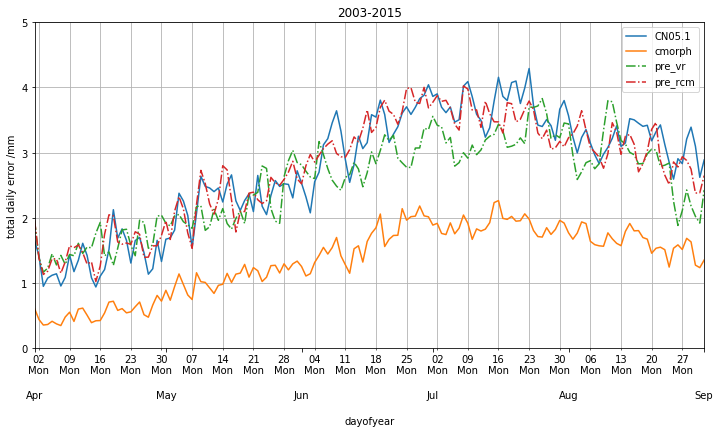

In [353]:
import matplotlib.dates as dates
# pd_plot = pd.concat([df_obs, df_mod,minus], axis=1)
plt.figure(figsize=(6,6))

ymin = 0.
ymax = 5.
idx = pd.date_range("2003-"+'04-01', "2003-"+'09-01')
# s = pd.Series(np.random.randn(len(idx)), index=idx)

# fig, ax = plt.subplots()
# ax.plot_date(idx.to_pydatetime(), 'v-')
ax = pd_plot.plot(figsize=(12,6),style=['-','-','-.','-.'])
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n'))
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
# plt.tight_layout()
# plt.show()
ax.set_ylabel("total daily error /mm")
plt.title("2003-2015")
# plt.savefig("./output_pic/series_dayofyear.png")